In [ ]:
!pip install Distance

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 180.3/180.3 kB 3.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for Distance: filename=Distance-0.1.3-py3-none-any.whl size=16258 sha256=c60c0f16358f5dc814862a7208ee471121172eaf15a019361f8e619b5c0e506d
  Stored in directory: /root/.cache/pip/wheels/e8/bb/de/f71bf63559ea9a921059a5405806f7ff6ed612a9231c4a9309
Successfully built Distance


In [ ]:
!unzip "/content/train.csv"

Archive:  /content/train.csv.zip
  inflating: train.csv               


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from subprocess import check_output

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import os
import gc
%pylab
import re
from nltk.corpus import stopwords
import distance
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup

%matplotlib inline

Using matplotlib backend: <object object at 0x7f628e583690>
Populating the interactive namespace from numpy and matplotlib


In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
!pip install fuzzywuzzy

In [ ]:
import warnings
warnings.filterwarnings("ignore")
from fuzzywuzzy import fuzz
from sklearn.manifold import TSNE
from wordcloud import WordCloud, STOPWORDS
from os import path
from PIL import Image

In [ ]:
#importing the data
#from google.colab import drive
#drive.mount('/content/drive')
df = pd.read_csv("/content/train.csv")

In [ ]:
df.shape[0]

404290

In [ ]:
dataset =  pd.read_csv("/content/train.csv")

In [ ]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


#EDA


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404290 non-null  int64 
 1   qid1          404290 non-null  int64 
 2   qid2          404290 non-null  int64 
 3   question1     404289 non-null  object
 4   question2     404288 non-null  object
 5   is_duplicate  404290 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


We are given a minimal number of data fields here, consisting of:

- id:  Looks like a simple rowID
- qid{1, 2}:  The unique ID of each question in the pair
- question{1, 2}:  The actual textual contents of the questions.
- is_duplicate:  The label that we are trying to predict - whether the two questions are duplicates of each other.

##Distribution of data points among output classes

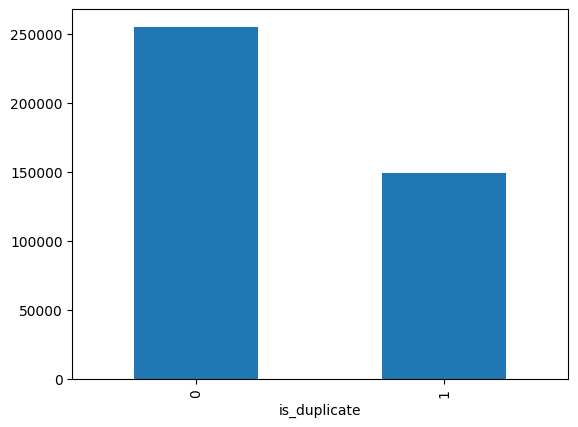

In [ ]:
df.groupby("is_duplicate")['id'].count().plot.bar()
plt.show()

In [ ]:
print("Percentage Question pairs that are not duplicates is", round(df[df['is_duplicate']==0].size/df.size *100  ,2))
print("Percentage Question pairs that are duplicates is", round(df[df['is_duplicate']==1].size/df.size *100  ,2))

Percentage Question pairs that are not duplicates is 63.08
Percentage Question pairs that are duplicates is 36.92


In [ ]:
qids= pd.Series(df['qid1'].tolist() + df['qid2'].tolist())
unique_ids= len(np.unique(qids))
qs_morethan_onetime = np.sum(qids.value_counts() > 1)
print("Number of unique questions is ", unique_ids)
print("Number of unique questions that appear more than once is ",np.sum(qids.value_counts()>1)," (", (np.sum(qids.value_counts()>1)) /(unique_ids) *100 ,")")
print("Most number of times a question appearing in the dataset:",np.max(qids.value_counts()))

q_values = qids.value_counts()

q_values= qids.values

Number of unique questions is  537933
Number of unique questions that appear more than once is  111780  ( 20.77953945937505 )
Most number of times a question appearing in the dataset: 157


In [ ]:
import seaborn as sns

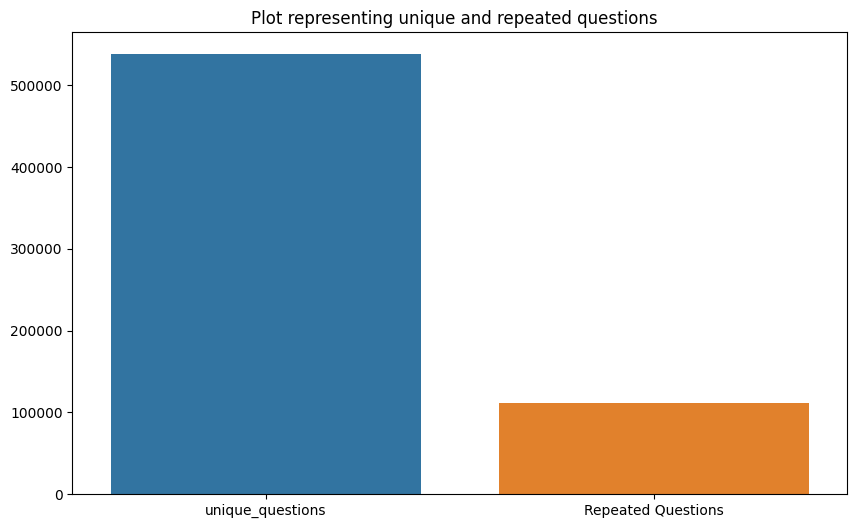

In [ ]:
x = ["unique_questions" , "Repeated Questions"]
y =  [unique_ids , qs_morethan_onetime]

plt.figure(figsize=(10, 6))
plt.title ("Plot representing unique and repeated questions  ")
sns.barplot(x = x,y = y)
plt.show()

In [ ]:
#checking whether there are any repeated pair of questions

pair_duplicates = df[['qid1','qid2','is_duplicate']].groupby(['qid1','qid2']).count().reset_index()

print ("Number of duplicate questions",(pair_duplicates).shape[0] - df.shape[0])

Number of duplicate questions 0


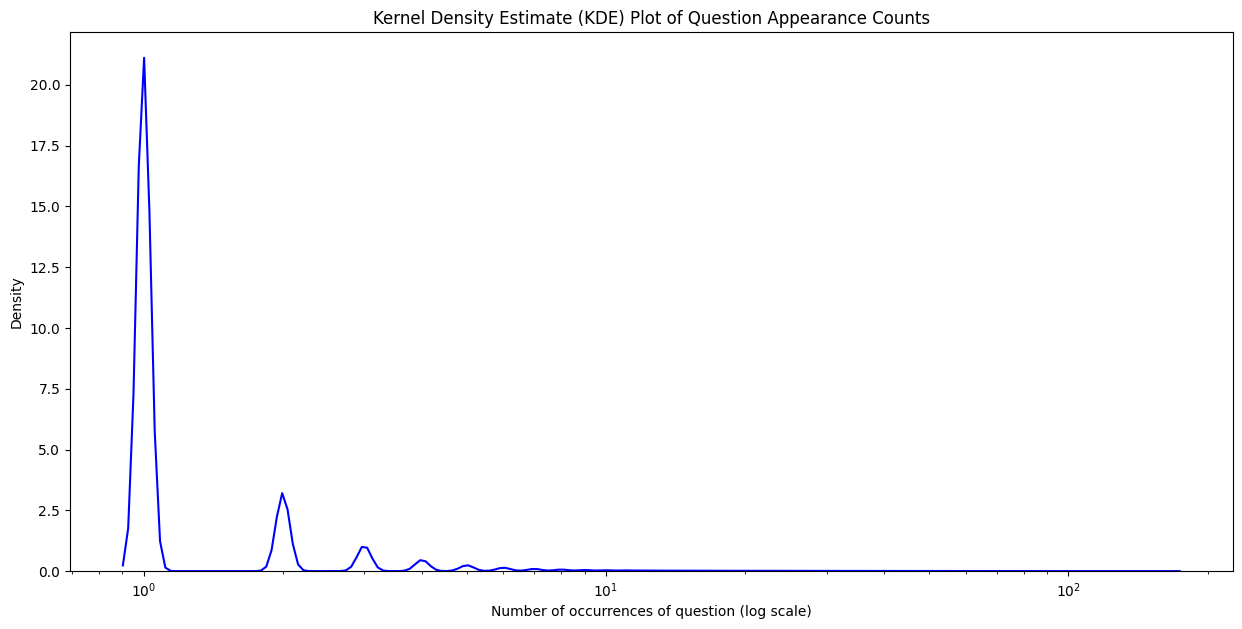

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(15, 7))

sns.kdeplot(qids.value_counts(), log_scale=True, color='b')

plt.title('Kernel Density Estimate (KDE) Plot of Question Appearance Counts')
plt.xlabel('Number of occurrences of question (log scale)')
plt.ylabel('Density')

plt.show()

In [ ]:
#dealing with null values
df[df.isnull().any(1)]

,id,qid1,qid2,question1,question2,is_duplicate
105780,105780,174363,174364,How can I develop android app?,NaN,0
201841,201841,303951,174364,How can I create an Android app?,NaN,0
363362,363362,493340,493341,NaN,My Chinese name is Haichao Yu. What English na...,0


In [ ]:
#filling an empty space inplace of Null values
df.dropna(inplace=True)
df.isnull().sum()

id              0
qid1            0
qid2            0
question1       0
question2       0
is_duplicate    0
dtype: int64

<ul>
<li>Now we have zero rows with null values</li>
</ul>


##Basic Feature Extraction (before cleaning)

Let us now construct a few features like:
 - ____freq_qid1____ = Frequency of qid1's
 - ____freq_qid2____ = Frequency of qid2's
 - ____q1len____ = Length of q1
 - ____q2len____ = Length of q2
 - ____q1_n_words____ = Number of words in Question 1
 - ____q2_n_words____ = Number of words in Question 2
 - ____word_Common____ = (Number of common unique words in Question 1 and Question 2)
 - ____word_Total____ =(Total num of words in Question 1 + Total num of words in Question 2)
 - ____word_share____ = (word_common)/(word_Total)
 - ____freq_q1+freq_q2____ = sum total of frequency of qid1 and qid2
 - ____freq_q1-freq_q2____ = absolute difference of frequency of qid1 and qid2

In [ ]:
temp1 = df[df['is_duplicate']==0] # non duplicate
temp2 = df[df['is_duplicate']==1]
temp1 = temp1.sample(n=50000)
temp2 = temp2.sample(n=50000)
df = pd.concat([temp1, temp2], ignore_index=True)
df.shape

(100000, 6)

In [ ]:
df

,id,qid1,qid2,question1,question2,is_duplicate
0,182449,279227,279228,Is Skyrim a good game to play if you're comple...,How does The Elder Scrolls series compare to t...,0
1,290470,65885,411769,Which colour matches with purple and green?,Which colour match with green?,0
2,10026,19463,19464,What is a love crime?,"If I love someone, is it a crime?",0
3,103758,171427,171428,If I remove someone from Snapchat and my accou...,"I blocked and unblocked someone on Snapchat, i...",0
4,237177,3627,336339,How do I deactivate a WhatsApp account tempora...,How do I deactivate my account on Snapchat?,0
...,...,...,...,...,...,...
99995,1698,3381,3382,When did humans start naming themselves? What'...,When in history did we start giving people names?,1
99996,403937,149184,104004,What's the best mistake you've ever made?,What is the most interesting mistake you have ...,1
99997,26804,49839,9064,What is the difference between core MBA and PGDM?,"What is the difference between any PGPs (PGDM,...",1
99998,79243,18917,36806,My questions are fine. Why does Quora keep say...,"Why does Quora keep marking my questions as ""n...",1


In [ ]:
df = df.sample(frac=1).reset_index(drop=True)

In [ ]:
#contructing the features
df['frequency_q1'] = df.groupby('qid1')['qid1'].transform('count')
df['frequency_q2'] = df.groupby('qid2')['qid2'].transform('count')
df['length_q1'] = df['question1'].str.len()
df['length_q2'] = df['question2'].str.len()
df['no_of_words_q1'] = df['question1'].apply(lambda row : len(str(row).split(' ')))
df['no_of_words_q2'] = df['question2'].apply(lambda row : len(str(row).split(' ')))

def normalized_word_Common(row):
        w1 = set(map(lambda word: word.lower().strip(), str(row['question1']).split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), str(row['question2']).split(" ")))
        return 1.0 * len(w1 & w2)

df['Common_words'] = df.apply(normalized_word_Common, axis=1)

def normalized_word_Total(row):
        w1 = set(map(lambda word: word.lower().strip(), str(row['question1']).split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), str(row['question2']).split(" ")))
        return 1.0 * (len(w1) + len(w2))
df['Total_words'] = df.apply(normalized_word_Total, axis=1)

def normalized_word_share(row):
        w1 = set(map(lambda word: word.lower().strip(), str(row['question1']).split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), str(row['question2']).split(" ")))
        return 1.0 * len(w1 & w2)/(len(w1) + len(w2))
df['word_share'] = df.apply(normalized_word_share, axis=1)

df.to_csv("df_fe_without_preprocessing_train.csv", index=False)

df.head()

,id,qid1,qid2,question1,question2,is_duplicate,frequency_q1,frequency_q2,length_q1,length_q2,no_of_words_q1,no_of_words_q2,Common_words,Total_words,word_share
0,263937,210636,48086,"Is America likely to go to war with Syria, and...",Why would Hillary Clinton start a war with Rus...,1,2,4,105,50,19,9,4.0,27.0,0.148148
1,132022,211518,211519,How do I create good content for an SEO client...,How can you create quality content when you're...,0,1,1,86,77,18,14,8.0,31.0,0.258065
2,187003,285104,285105,"Did crime rates in NY drop after ""stop and fri...",Has there been any change in the crime rate in...,1,1,1,76,94,13,18,5.0,28.0,0.178571
3,266888,384134,384135,Why do some people steal when they have money?,Why do people steal?,0,1,1,46,20,9,4,3.0,13.0,0.230769
4,51182,90823,90824,"In a PwC interview, what reason can you give f...",Who will big 4 prefer to recruit CA or CWA?,0,1,1,106,43,23,10,2.0,32.0,0.062500


<ul><li>Here are some questions have only one single words.</li>
</ul>

In [ ]:
print ("Minimum length of the questions in question1 : " , min(df['no_of_words_q1']))

print ("Minimum length of the questions in question2 : " , min(df['no_of_words_q2']))

print ("Number of Questions with minimum length [question1] :", df[df['no_of_words_q1']== 1].shape[0])
print ("Number of Questions with minimum length [question2] :", df[df['no_of_words_q2']== 1].shape[0])

Minimum length of the questions in question1 :  1
Minimum length of the questions in question2 :  1
Number of Questions with minimum length [question1] : 16
Number of Questions with minimum length [question2] : 6


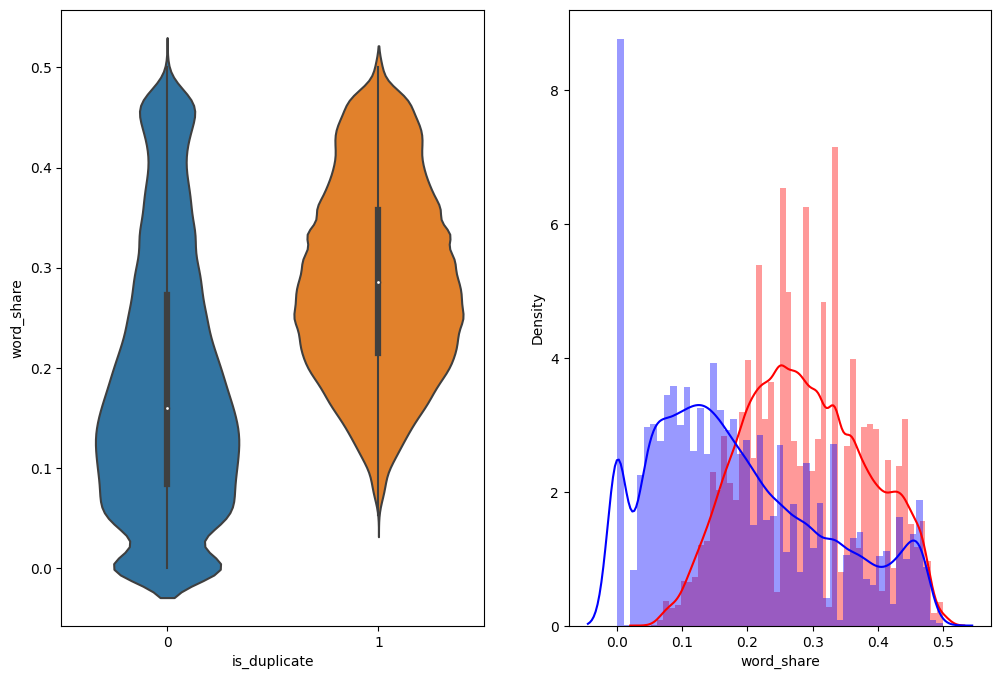

In [ ]:
#plot for feature word share
plt.figure(figsize=(12, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'word_share', data = df[0:])

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['word_share'] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['word_share'] , label = "0" , color = 'blue' )
plt.show()

- The distributions for normalized word_share have some overlap on the far right-hand side, i.e., there are quite a lot of questions with high word similarity
- The average word share and Common no. of words of qid1 and qid2 is more when they are duplicate(Similar)

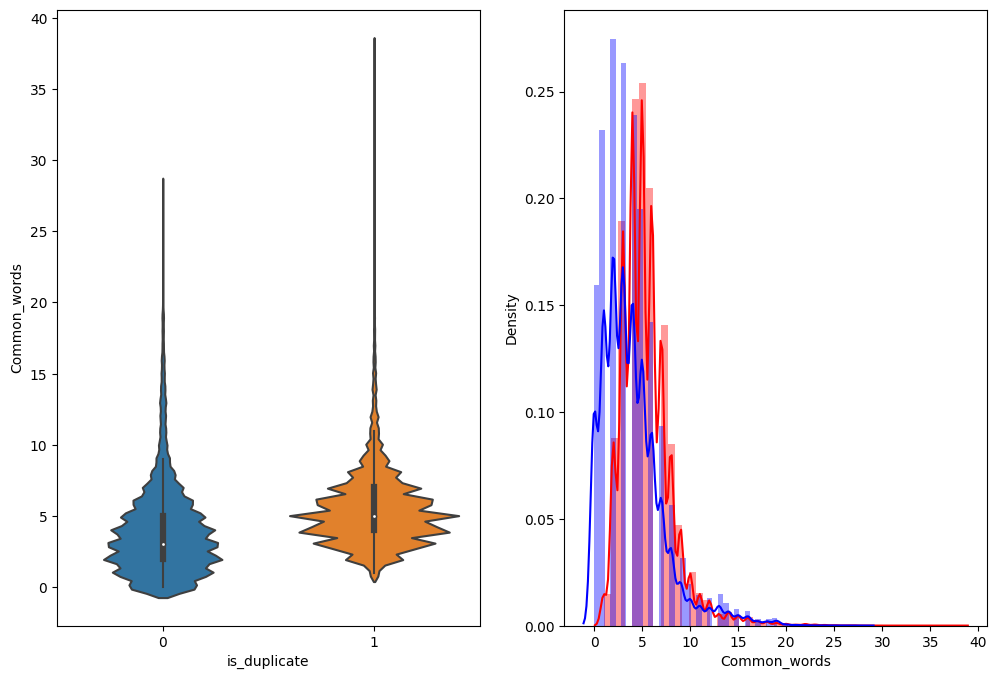

In [ ]:
#plot for feature common word
plt.figure(figsize=(12, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'Common_words', data = df[0:])

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['Common_words'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['Common_words'][0:] , label = "0" , color = 'blue' )
plt.show()

<p> The distributions of the word_Common feature in similar and non-similar questions are highly overlapping </p>

## Preprocessing:
    - Removing html tags
    - Removing Punctuations
    - Performing stemming
    - Removing Stopwords
    - Expanding contractions etc.

In [ ]:
# To get the results in 4 decimal points
SAFE_DIV = 0.0001

STOP_WORDS = stopwords.words("english")


def preprocess(x):
    x = str(x).lower()
    x = x.replace(",000,000", "m").replace(",000", "k").replace("′", "'").replace("’", "'")\
                           .replace("won't", "will not").replace("cannot", "can not").replace("can't", "can not")\
                           .replace("n't", " not").replace("what's", "what is").replace("it's", "it is")\
                           .replace("'ve", " have").replace("i'm", "i am").replace("'re", " are")\
                           .replace("he's", "he is").replace("she's", "she is").replace("'s", " own")\
                           .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ")\
                           .replace("€", " euro ").replace("'ll", " will")
    x = re.sub(r"([0-9]+)000000", r"\1m", x)
    x = re.sub(r"([0-9]+)000", r"\1k", x)


    porter = PorterStemmer()
    pattern = re.compile('\W')

    if type(x) == type(''):
        x = re.sub(pattern, ' ', x)


    if type(x) == type(''):
        x = porter.stem(x)
        example1 = BeautifulSoup(x)
        x = example1.get_text()
    return x

Advanced NLP and Fuzzy Features:

- first_word_equivalence : Check if the first word of both the questions is equal or not.
- last_word_equivalence : Check if the last word of both questions is equal or not.
- absolute_length_difference : Absolute value of length difference.
- mean_length : Average Token Length of both Questions.
- longest_substring_ratio : Ratio of length of longest common substring to the minimum
length of the token count of Q1 and Q2
- fuzz_ratio : String similarity - the ratio of similarity between Q1 and Q2 whose value lies
between 0 and 100.
- fuzz_partial_ratio: Partial String Similarity - the ratio of the most similar substring
between Q1 and Q2 as a number between 0 and 100.
- token_sort_ratio : Tokenizing the string (Q1 or Q2), sorting the tokens alphabetically,
and then joining them back into a string to find the string similarity ratio between the two.
Value lies between 0 and 100.
- token_set_ratio : All tokens of both strings (Q1 and Q2) are taken and the ratio between
the sorted intersection and the sorted remainder is calculated. The value lies between 0
and 100.

In [ ]:
def get_token_features(q1,q2):
   token_features =[0.0] *10
   #converting the sentence into tokens
   q1_tokens= q1.split()
   q2_tokens= q2.split()

   if len(q1_tokens) == 0 or len(q2_tokens) ==0 :
    return token_features
  #Get non-stopwords in questions
   q1_words = set([word for word in q1_tokens if word not in STOP_WORDS])
   q2_words = set([word for word in q2_tokens if word not in STOP_WORDS])

   #Get the stopwords in Questions
   q1_stops = set([word for word in q1_tokens if word in STOP_WORDS])
   q2_stops = set([word for word in q2_tokens if word in STOP_WORDS])

   # Get the common non-stopwords from Question pair
   common_word_count = len(q1_words.intersection(q2_words))

   # Get the common stopwords from Question pair
   common_stop_count = len(q1_stops.intersection(q2_stops))

    # Get the common Tokens from Question pair
   common_token_count = len(set(q1_tokens).intersection(set(q2_tokens)))

 #  token_features[0] = common_word_count / (min(len(q1_words), len(q2_words)) + SAFE_DIV)
 #  token_features[1] = common_word_count / (max(len(q1_words), len(q2_words)) + SAFE_DIV)
 #  token_features[2] = common_stop_count / (min(len(q1_stops), len(q2_stops)) + SAFE_DIV)
 #  token_features[3] = common_stop_count / (max(len(q1_stops), len(q2_stops)) + SAFE_DIV)
 #  token_features[4] = common_token_count / (min(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
 #  token_features[5] = common_token_count / (max(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)

   # Last word of both question is same or not
   token_features[0] = int(q1_tokens[-1] == q2_tokens[-1])

    # First word of both question is same or not
   token_features[1] = int(q1_tokens[0] == q2_tokens[0])

   token_features[2] = abs(len(q1_tokens) - len(q2_tokens))

   #Average Token Length of both Questions
   token_features[3] = (len(q1_tokens) + len(q2_tokens))/2
   return token_features

def get_longest_substr_ratio(a, b):
    strs = list(distance.lcsubstrings(a, b))
    if len(strs) == 0:
        return 0
    else:
        return len(strs[0]) / (min(len(a), len(b)) + 1)



def extract_features(df):
    # preprocessing each question
    df["question1"] = df["question1"].fillna("").apply(preprocess)
    df["question2"] = df["question2"].fillna("").apply(preprocess)

    print("token features...")

    # Merging Features with dataset

    token_features = df.apply(lambda x: get_token_features(x["question1"], x["question2"]), axis=1)

  #  df["cwc_min"]       = list(map(lambda x: x[0], token_features))
   # df["cwc_max"]       = list(map(lambda x: x[1], token_features))
   # df["csc_min"]       = list(map(lambda x: x[2], token_features))
   # df["csc_max"]       = list(map(lambda x: x[3], token_features))
   # df["ctc_min"]       = list(map(lambda x: x[4], token_features))
   # df["ctc_max"]       = list(map(lambda x: x[5], token_features))
    df["last_word_equivalence"]  = list(map(lambda x: x[0], token_features))
    df["first_word_equivalence"] = list(map(lambda x: x[1], token_features))
    df["absolute_length_difference"]  = list(map(lambda x: x[2], token_features))
    df["mean_length"]      = list(map(lambda x: x[3], token_features))


    print("fuzzy features..")

    df["token_set_ratio"]       = df.apply(lambda x: fuzz.token_set_ratio(x["question1"], x["question2"]), axis=1)
    df["token_sort_ratio"]      = df.apply(lambda x: fuzz.token_sort_ratio(x["question1"], x["question2"]), axis=1)
    df["fuzz_ratio"]            = df.apply(lambda x: fuzz.QRatio(x["question1"], x["question2"]), axis=1)
    df["fuzz_partial_ratio"]    = df.apply(lambda x: fuzz.partial_ratio(x["question1"], x["question2"]), axis=1)
    df["longest_substring_ratio"]  = df.apply(lambda x: get_longest_substr_ratio(x["question1"], x["question2"]), axis=1)
    return df

In [ ]:
df2 = extract_features(df)
df2.to_csv("nlp_features_train.csv", index=False)

token features...
fuzzy features..


In [ ]:
df2 = pd.read_csv("/content/nlp_features_train.csv")
df2

,id,qid1,qid2,question1,question2,is_duplicate,frequency_q1,frequency_q2,length_q1,length_q2,...,word_share,last_word_equivalence,first_word_equivalence,absolute_length_difference,mean_length,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substring_ratio
0,263937,210636,48086,is america likely to go to war with syria and...,why would hillary clinton start a war with rus...,1,2,4,105,50,...,0.148148,0.0,0.0,10.0,14.0,78,52,35,53,0.333333
1,132022,211518,211519,how do i create good content for an seo client...,how can you create quality content when you ar...,0,1,1,86,77,...,0.258065,1.0,1.0,4.0,17.0,75,66,69,67,0.265823
2,187003,285104,285105,did crime rates in ny drop after stop and fri...,has there been any change in the crime rate in...,1,1,1,76,94,...,0.178571,0.0,0.0,5.0,15.5,55,48,52,62,0.233766
3,266888,384134,384135,why do some people steal when they have money,why do people steal,0,1,1,46,20,...,0.230769,0.0,1.0,5.0,6.5,100,59,59,80,0.666667
4,51182,90823,90824,in a pwc interview what reason can you give f...,who will big 4 prefer to recruit ca or cwa,0,1,1,106,43,...,0.062500,0.0,0.0,13.0,16.5,41,41,26,38,0.159091
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,212575,317688,165101,what are the difference between medicaid and m...,medicine and healthcare what is the differenc...,1,1,1,54,79,...,0.333333,0.0,0.0,3.0,9.5,86,78,72,89,0.672727
99996,45063,80799,80800,can science prove or disprove the existence of...,does science have evidence for proving the exi...,1,2,1,51,60,...,0.263158,1.0,0.0,1.0,9.5,72,66,64,72,0.423077
99997,245827,358746,358747,how do girls everywhere have awesome hair that...,what is the best way to keep hair shiny and fr...,0,1,1,139,71,...,0.078947,0.0,0.0,10.0,21.0,43,37,32,39,0.097222
99998,305502,428912,268709,what can i do if i want to have sex with a girl,i want to have sex with a girl what can i do,1,1,1,48,46,...,0.391304,0.0,0.0,1.0,12.5,100,97,65,81,0.659574


In [ ]:
df2.shape

(100000, 24)

In [ ]:
df2.head(2)

,id,qid1,qid2,question1,question2,is_duplicate,frequency_q1,frequency_q2,length_q1,length_q2,...,word_share,last_word_equivalence,first_word_equivalence,absolute_length_difference,mean_length,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substring_ratio
0,263937,210636,48086,is america likely to go to war with syria and...,why would hillary clinton start a war with rus...,1,2,4,105,50,...,0.148148,0.0,0.0,10.0,14.0,78,52,35,53,0.333333
1,132022,211518,211519,how do i create good content for an seo client...,how can you create quality content when you ar...,0,1,1,86,77,...,0.258065,1.0,1.0,4.0,17.0,75,66,69,67,0.265823


- Creating Word Cloud of Duplicates and Non-Duplicates Question pairs
- We can observe the most frequent occuring words

In [ ]:
df_duplicate = df2[df2['is_duplicate'] == 1]
dfp_nonduplicate = df2[df2['is_duplicate'] == 0]

# Converting 2d array of q1 and q2 and flatten the array: like {{1,2},{3,4}} to {1,2,3,4}
p = np.dstack([df_duplicate["question1"], df_duplicate["question2"]]).flatten()
n = np.dstack([dfp_nonduplicate["question1"], dfp_nonduplicate["question2"]]).flatten()

print ("Number of data points in class 1 (duplicate pairs) :",len(p))
print ("Number of data points in class 0 (non duplicate pairs) :",len(n))

#Saving the np array into a text file
np.savetxt('train_p.txt', p, delimiter=' ', fmt='%s')
np.savetxt('train_n.txt', n, delimiter=' ', fmt='%s')

Number of data points in class 1 (duplicate pairs) : 100000
Number of data points in class 0 (non duplicate pairs) : 100000


In [ ]:
df_duplicate.shape

(50000, 24)

In [ ]:
dfp_nonduplicate.shape

(50000, 24)

In [ ]:
# reading the text files and removing the Stop Words:
d = path.dirname('.')

textp_w = open(path.join(d, 'train_p.txt')).read()
textn_w = open(path.join(d, 'train_n.txt')).read()
stopwords = set(STOPWORDS)
stopwords.add("said")
stopwords.add("br")
stopwords.add(" ")
stopwords.remove("not")
stopwords.remove("no")
stopwords.remove("like")

print ("Total number of words in duplicate pair questions :",len(textp_w))
print ("Total number of words in non duplicate pair questions :",len(textn_w))

Total number of words in duplicate pair questions : 5391121
Total number of words in non duplicate pair questions : 6505001


**Word Clouds generated from  duplicate pair question's text**

Word Cloud for Duplicate Question pairs


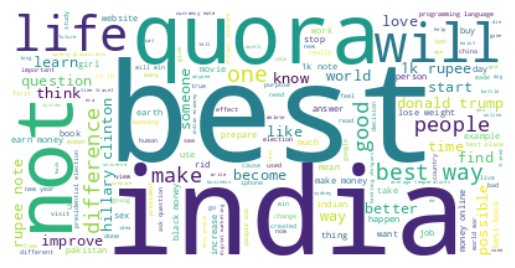

In [ ]:
wc = WordCloud(background_color="white", max_words=len(textp_w), stopwords=stopwords)
wc.generate(textp_w)
print ("Word Cloud for Duplicate Question pairs")
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

Word Cloud for Duplicate Question pairs


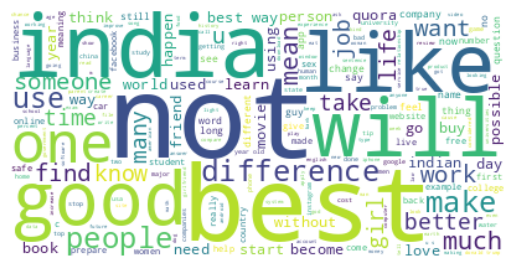

In [ ]:
wc = WordCloud(background_color="white", max_words=len(textn_w), stopwords=stopwords)
wc.generate(textn_w)
print ("Word Cloud for Duplicate Question pairs")
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

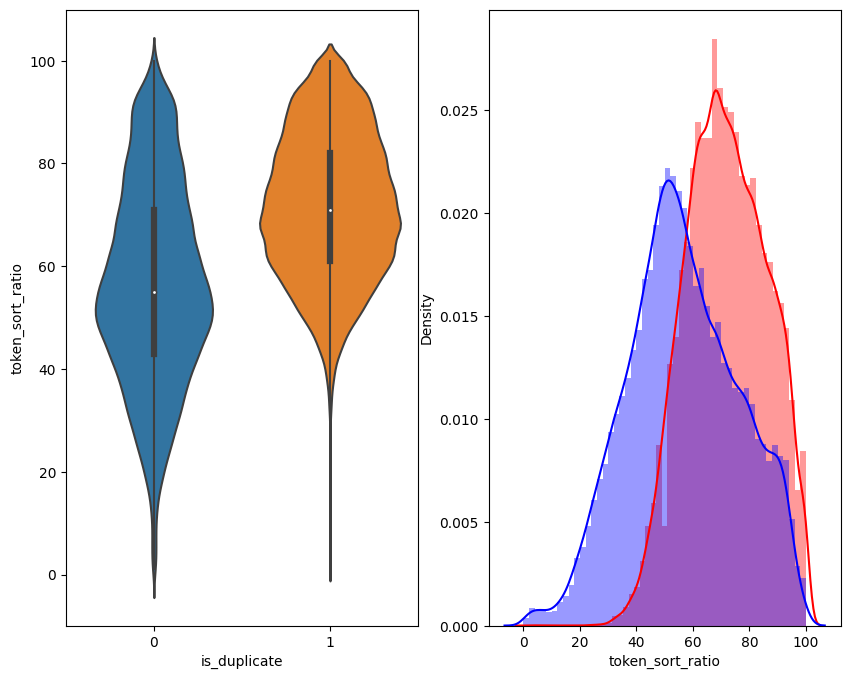

In [ ]:
# Distribution of the token_sort_ratio
plt.figure(figsize=(10, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'token_sort_ratio', data = df2[0:] , )

plt.subplot(1,2,2)
sns.distplot(df2[df2['is_duplicate'] == 1.0]['token_sort_ratio'][0:] , label = "1", color = 'red')
sns.distplot(df2[df2['is_duplicate'] == 0.0]['token_sort_ratio'][0:] , label = "0" , color = 'blue' )
plt.show()

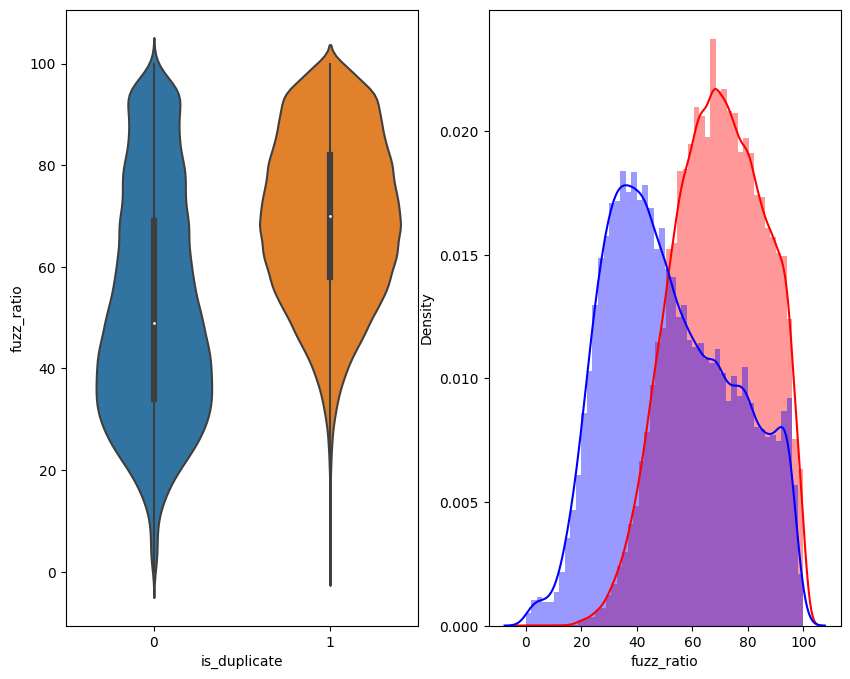

In [ ]:
# Distribution of the fuzz_ratio
plt.figure(figsize=(10, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'fuzz_ratio', data = df2[0:] , )

plt.subplot(1,2,2)
sns.distplot(df2[df2['is_duplicate'] == 1.0]['fuzz_ratio'][0:] , label = "1", color = 'red')
sns.distplot(df2[df2['is_duplicate'] == 0.0]['fuzz_ratio'][0:] , label = "0" , color = 'blue' )
plt.show()

In [ ]:
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
from tqdm import tqdm
import spacy

In [ ]:
df3 = dataset.copy()

df3['question1'] = df3['question1'].apply(lambda x: str(x))
df3['question2'] = df3['question2'].apply(lambda x: str(x))
df3.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [ ]:
df3

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0
...,...,...,...,...,...,...
404285,404285,433578,379845,How many keywords are there in the Racket prog...,How many keywords are there in PERL Programmin...,0
404286,404286,18840,155606,Do you believe there is life after death?,Is it true that there is life after death?,1
404287,404287,537928,537929,What is one coin?,What's this coin?,0
404288,404288,537930,537931,What is the approx annual cost of living while...,I am having little hairfall problem but I want...,0


In [ ]:
temp_df = pd.DataFrame(df2.id, index= df2.index)
temp_df = temp_df.merge(df3, on='id',how='inner')

In [ ]:
temp_df

,id,qid1,qid2,question1,question2,is_duplicate
0,263937,210636,48086,"Is America likely to go to war with Syria, and...",Why would Hillary Clinton start a war with Rus...,1
1,132022,211518,211519,How do I create good content for an SEO client...,How can you create quality content when you're...,0
2,187003,285104,285105,"Did crime rates in NY drop after ""stop and fri...",Has there been any change in the crime rate in...,1
3,266888,384134,384135,Why do some people steal when they have money?,Why do people steal?,0
4,51182,90823,90824,"In a PwC interview, what reason can you give f...",Who will big 4 prefer to recruit CA or CWA?,0
...,...,...,...,...,...,...
99995,212575,317688,165101,What are the difference between medicaid and m...,Medicine and Healthcare: What is the differenc...,1
99996,45063,80799,80800,Can science prove or disprove the existence of...,Does science have evidence for proving the exi...,1
99997,245827,358746,358747,How do girls everywhere have awesome hair that...,What is the best way to keep hair shiny and fr...,0
99998,305502,428912,268709,What can I do if I want to have sex with a girl?,"I want to have sex with a girl, what can i do?",1


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

questions = list(temp_df['question1']) + list(temp_df['question2'])

tfidf = TfidfVectorizer(lowercase=False)
tfidf_matrix = tfidf.fit_transform(questions)

# Get feature names
feature_names = tfidf.get_feature_names_out()

# Now, you can create a dictionary with word as the key and tf-idf score as the value
word2tfidf = dict(zip(feature_names, tfidf.idf_))

In [ ]:
word2tfidf

{'00': 10.161555207794251,
 '000': 7.281821848103142,
 '0002': 12.512930464957728,
 '000INR': 12.512930464957728,
 '000Rs': 12.107465356849564,
 '000rs': 12.512930464957728,
 '000s': 12.512930464957728,
 '0015': 12.512930464957728,
 '0019': 11.819783284397783,
 '0051': 12.107465356849564,
 '008801703772104': 12.512930464957728,
 '00AM': 12.512930464957728,
 '00GHz': 12.512930464957728,
 '00am': 11.596639733083574,
 '00s': 12.512930464957728,
 '01': 10.641128288056137,
 '014': 12.512930464957728,
 '01GBP': 12.512930464957728,
 '02': 11.819783284397783,
 '03': 11.819783284397783,
 '032': 12.107465356849564,
 '0320': 12.512930464957728,
 '035': 12.512930464957728,
 '038': 12.512930464957728,
 '04': 10.372864301461458,
 '045': 12.512930464957728,
 '05': 11.596639733083574,
 '050': 12.512930464957728,
 '054': 12.512930464957728,
 '055': 12.512930464957728,
 '0569': 12.512930464957728,
 '058': 12.512930464957728,
 '05_mar': 12.512930464957728,
 '06': 11.008853068181454,
 '062': 12.5129304649

- After we find TF-IDF scores, we convert each question to a weighted average of word2vec vectors by these scores.
- here we use a pre-trained GLOVE model which comes free with "Spacy".  https://spacy.io/usage/vectors-similarity
- It is trained on Wikipedia and therefore, it is stronger in terms of word semantics.

In [ ]:
# en_vectors_web_lg, which includes over 1 million unique vectors.
nlp = spacy.load('en_core_web_sm')

vecs1 = []
for qu1 in tqdm(list(temp_df['question1'])):
    doc1 = nlp(qu1)
    # 384 is the number of dimensions of vectors
    mean_vec1 = np.zeros([len(doc1), len(doc1[0].vector)])
    for word1 in doc1:
        # word2vec
        vec1 = word1.vector
        # fetch df score
        try:
            idf = word2tfidf[str(word1)]
        except:
            idf = 0
        # compute final vec
        mean_vec1 += vec1 * idf
    mean_vec1 = mean_vec1.mean(axis=0)
    vecs1.append(mean_vec1)
df2['q1_feats_m'] = list(vecs1)

100%|██████████| 100000/100000 [13:49<00:00, 120.61it/s]


In [ ]:
doc1

Does Hillary have Parkinson disease?

In [ ]:
vecs2 = []
for qu2 in tqdm(list(temp_df['question2'])):
    doc2 = nlp(qu2)
    mean_vec2 = np.zeros([len(doc1), len(doc2[0].vector)])
    for word2 in doc2:
        # word2vec
        vec2 = word2.vector
        # fetch df score
        try:
            idf = word2tfidf[str(word2)]
        except:
            #print word
            idf = 0
        # compute final vec
        mean_vec2 += vec2 * idf
        #the above line gives the value for each word which is added up
    mean_vec2 = mean_vec2.mean(axis=0)
    vecs2.append(mean_vec2)
df2['q2_feats_m'] = list(vecs2)

100%|██████████| 100000/100000 [13:30<00:00, 123.33it/s]


In [ ]:
df2

,id,qid1,qid2,question1,question2,is_duplicate,frequency_q1,frequency_q2,length_q1,length_q2,...,first_word_equivalence,absolute_length_difference,mean_length,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substring_ratio,q1_feats_m,q2_feats_m
0,263937,210636,48086,is america likely to go to war with syria and...,why would hillary clinton start a war with rus...,1,2,4,105,50,...,0.0,10.0,14.0,78,52,35,53,0.333333,"[-22.595134913921356, -29.757706120610237, -8....","[-26.484549641609192, -24.64345371723175, 7.98..."
1,132022,211518,211519,how do i create good content for an seo client...,how can you create quality content when you ar...,0,1,1,86,77,...,1.0,4.0,17.0,75,66,69,67,0.265823,"[-7.120418667793274, -28.429120015352964, -14....","[-9.835370302200317, -16.730433493852615, -0.7..."
2,187003,285104,285105,did crime rates in ny drop after stop and fri...,has there been any change in the crime rate in...,1,1,1,76,94,...,0.0,5.0,15.5,55,48,52,62,0.233766,"[20.84768843650818, -29.082162231206894, 8.074...","[23.770628035068512, -63.5279244184494, 5.7547..."
3,266888,384134,384135,why do some people steal when they have money,why do people steal,0,1,1,46,20,...,1.0,5.0,6.5,100,59,59,80,0.666667,"[-6.721450209617615, -17.209407567977905, -15....","[3.974482536315918, -20.1181697845459, 4.71669..."
4,51182,90823,90824,in a pwc interview what reason can you give f...,who will big 4 prefer to recruit ca or cwa,0,1,1,106,43,...,0.0,13.0,16.5,41,41,26,38,0.159091,"[-14.571113511919975, -57.43712235428393, -1.2...","[-41.85037738084793, -40.57910060510039, -0.98..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,212575,317688,165101,what are the difference between medicaid and m...,medicine and healthcare what is the differenc...,1,1,1,54,79,...,0.0,3.0,9.5,86,78,72,89,0.672727,"[-16.88094985485077, 2.81468266248703, 11.7726...","[-36.654210686683655, 0.1583442986011505, -10...."
99996,45063,80799,80800,can science prove or disprove the existence of...,does science have evidence for proving the exi...,1,2,1,51,60,...,0.0,1.0,9.5,72,66,64,72,0.423077,"[-20.965347290039062, -33.41025936603546, -4.9...","[-32.09706461429596, 9.713308334350586, 0.5222..."
99997,245827,358746,358747,how do girls everywhere have awesome hair that...,what is the best way to keep hair shiny and fr...,0,1,1,139,71,...,0.0,10.0,21.0,43,37,32,39,0.097222,"[31.217246770858765, -38.782871678471565, 27.0...","[12.996192052960396, -11.247407302260399, -2.7..."
99998,305502,428912,268709,what can i do if i want to have sex with a girl,i want to have sex with a girl what can i do,1,1,1,48,46,...,0.0,1.0,12.5,100,97,65,81,0.659574,"[-14.380379676818848, -18.641545921564102, 0.4...","[-12.608859121799469, -9.064420521259308, 11.5..."


In [ ]:
dfnlp = pd.read_csv("/content/nlp_features_train.csv", encoding='latin-1', error_bad_lines=False)
dfppro = pd.read_csv("/content/df_fe_without_preprocessing_train.csv", encoding='latin-1', error_bad_lines=False)

In [ ]:
dfnlp.columns

Index(['id', 'qid1', 'qid2', 'question1', 'question2', 'is_duplicate',
       'frequency_q1', 'frequency_q2', 'length_q1', 'length_q2',
       'no_of_words_q1', 'no_of_words_q2', 'Common_words', 'Total_words',
       'word_share', 'last_word_equivalence', 'first_word_equivalence',
       'absolute_length_difference', 'mean_length', 'token_set_ratio',
       'token_sort_ratio', 'fuzz_ratio', 'fuzz_partial_ratio',
       'longest_substring_ratio'],
      dtype='object')

In [ ]:
dfnlp.drop(['qid1','qid2','question1','question2','frequency_q1','frequency_q2','length_q1','length_q2','no_of_words_q1','no_of_words_q2','Common_words','Total_words','word_share'],axis=1)

,id,is_duplicate,last_word_equivalence,first_word_equivalence,absolute_length_difference,mean_length,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substring_ratio
0,263937,1,0.0,0.0,10.0,14.0,78,52,35,53,0.333333
1,132022,0,1.0,1.0,4.0,17.0,75,66,69,67,0.265823
2,187003,1,0.0,0.0,5.0,15.5,55,48,52,62,0.233766
3,266888,0,0.0,1.0,5.0,6.5,100,59,59,80,0.666667
4,51182,0,0.0,0.0,13.0,16.5,41,41,26,38,0.159091
...,...,...,...,...,...,...,...,...,...,...,...
99995,212575,1,0.0,0.0,3.0,9.5,86,78,72,89,0.672727
99996,45063,1,1.0,0.0,1.0,9.5,72,66,64,72,0.423077
99997,245827,0,0.0,0.0,10.0,21.0,43,37,32,39,0.097222
99998,305502,1,0.0,0.0,1.0,12.5,100,97,65,81,0.659574


In [ ]:
dfppro.drop(['qid1','qid2','question1','question2','is_duplicate'],axis=1)

,id,frequency_q1,frequency_q2,length_q1,length_q2,no_of_words_q1,no_of_words_q2,Common_words,Total_words,word_share
0,263937,2,4,105,50,19,9,4.0,27.0,0.148148
1,132022,1,1,86,77,18,14,8.0,31.0,0.258065
2,187003,1,1,76,94,13,18,5.0,28.0,0.178571
3,266888,1,1,46,20,9,4,3.0,13.0,0.230769
4,51182,1,1,106,43,23,10,2.0,32.0,0.062500
...,...,...,...,...,...,...,...,...,...,...
99995,212575,1,1,54,79,8,11,6.0,18.0,0.333333
99996,45063,2,1,51,60,9,10,5.0,19.0,0.263158
99997,245827,1,1,139,71,26,16,3.0,38.0,0.078947
99998,305502,1,1,48,46,13,12,9.0,23.0,0.391304


In [ ]:
df = df2.copy()

In [ ]:
df3.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [ ]:
df1 = dfnlp.drop(['qid1','qid2','question1','question2','frequency_q1','frequency_q2','length_q1','length_q2','no_of_words_q1','no_of_words_q2','Common_words','Total_words','word_share'],axis=1)
df2 = dfppro.drop(['qid1','qid2','question1','question2','is_duplicate'],axis=1)
df3 = df.drop(['qid1','qid2','question1','question2','is_duplicate'],axis=1)
df3_q1 = pd.DataFrame(df3.q1_feats_m.values.tolist(), index= df3.index)
df3_q2 = pd.DataFrame(df3.q2_feats_m.values.tolist(), index= df3.index)

In [ ]:
df1.head()

,id,is_duplicate,last_word_equivalence,first_word_equivalence,absolute_length_difference,mean_length,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substring_ratio
0,263937,1,0.0,0.0,10.0,14.0,78,52,35,53,0.333333
1,132022,0,1.0,1.0,4.0,17.0,75,66,69,67,0.265823
2,187003,1,0.0,0.0,5.0,15.5,55,48,52,62,0.233766
3,266888,0,0.0,1.0,5.0,6.5,100,59,59,80,0.666667
4,51182,0,0.0,0.0,13.0,16.5,41,41,26,38,0.159091


In [ ]:
df2.head()

,id,frequency_q1,frequency_q2,length_q1,length_q2,no_of_words_q1,no_of_words_q2,Common_words,Total_words,word_share
0,263937,2,4,105,50,19,9,4.0,27.0,0.148148
1,132022,1,1,86,77,18,14,8.0,31.0,0.258065
2,187003,1,1,76,94,13,18,5.0,28.0,0.178571
3,266888,1,1,46,20,9,4,3.0,13.0,0.230769
4,51182,1,1,106,43,23,10,2.0,32.0,0.062500


In [ ]:
df3_q1.head()

,0,1,2,3,4,5,6,7,8,9,...,86,87,88,89,90,91,92,93,94,95
0,-22.595135,-29.757706,-8.374319,4.721210,19.223674,-17.814969,52.907136,33.148523,16.775510,6.195714,...,-9.631240,1.099263,-20.170507,27.845968,-24.925095,-30.683598,131.926463,32.951434,0.517273,41.949177
1,-7.120419,-28.429120,-14.979146,11.401328,9.012864,-10.811786,42.421833,2.265342,-17.293665,-17.107274,...,12.427400,-20.749216,-20.834614,47.149818,-12.142380,-18.508195,64.123283,60.158007,-9.218378,34.012791
2,20.847688,-29.082162,8.074051,-15.952188,-34.151455,-2.393922,36.859231,48.991268,-25.576108,-25.670742,...,-6.769487,2.736302,-41.968561,22.018997,14.559771,-11.096740,81.396363,80.880519,12.083106,54.684716
3,-6.721450,-17.209408,-15.940380,8.381656,0.927240,-13.855129,30.676736,2.735164,-4.078739,-16.297985,...,-11.884045,-19.951469,-8.656801,1.444602,-4.028347,8.013222,21.146564,23.973859,15.830143,18.141565
4,-14.571114,-57.437122,-1.264934,17.804447,9.488760,-26.352449,47.957230,45.434529,-45.984732,-21.333075,...,11.050128,-25.147243,-13.315149,73.100474,10.554729,9.338346,85.516363,20.411658,-1.291755,31.012767


In [ ]:
print("Number of features in nlp dataframe :", df1.shape[1])
print("Number of features in preprocessed dataframe :", df2.shape[1])
print("Number of features in question1 w2v  dataframe :", df3_q1.shape[1])
print("Number of features in question2 w2v  dataframe :", df3_q2.shape[1])
print("Number of features in final dataframe  :", df1.shape[1]+df2.shape[1]+df3_q1.shape[1]+df3_q2.shape[1]-1)

Number of features in nlp dataframe : 11
Number of features in preprocessed dataframe : 10
Number of features in question1 w2v  dataframe : 96
Number of features in question2 w2v  dataframe : 96
Number of features in final dataframe  : 212


In [ ]:
df.shape

(100000, 26)

In [ ]:
df1.shape

(100000, 11)

In [ ]:
df2.shape

(100000, 10)

In [ ]:
df3.shape

(100000, 21)

In [ ]:
df3_q1.shape

(100000, 96)

In [ ]:
df3_q2.shape

(100000, 96)

In [ ]:
df3_q1['id'] = df1['id']
df3_q2['id'] = df1['id']
df1 = df1.merge(df2, on='id',how='left')
df2 = df3_q1.merge(df3_q2, on='id',how='left')
result = df1.merge(df2, on='id',how='left')
result.to_csv('final_features.csv')

In [ ]:
result.columns

Index(['id', 'is_duplicate', 'last_word_equivalence', 'first_word_equivalence',
       'absolute_length_difference', 'mean_length', 'token_set_ratio',
       'token_sort_ratio', 'fuzz_ratio', 'fuzz_partial_ratio',
       ...
       '86_y', '87_y', '88_y', '89_y', '90_y', '91_y', '92_y', '93_y', '94_y',
       '95_y'],
      dtype='object', length=212)

In [ ]:
result.drop('id',axis=1,inplace=True)

In [ ]:
result.shape

(100000, 211)

In [ ]:
result.head()

,is_duplicate,last_word_equivalence,first_word_equivalence,absolute_length_difference,mean_length,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substring_ratio,...,86_y,87_y,88_y,89_y,90_y,91_y,92_y,93_y,94_y,95_y
0,1,0.0,0.0,10.0,14.0,78,52,35,53,0.333333,...,-1.284390,-12.939018,-21.496337,15.040951,-2.568845,-30.987176,59.635279,13.381462,5.599260,28.213140
1,0,1.0,1.0,4.0,17.0,75,66,69,67,0.265823,...,5.268672,-7.690371,-0.941940,41.042536,-6.492232,-21.263461,60.921931,46.930878,-15.656119,34.826345
2,1,0.0,0.0,5.0,15.5,55,48,52,62,0.233766,...,35.324096,-16.896805,-41.331501,27.271720,-32.083770,-20.166226,60.774897,74.096672,14.971708,19.064477
3,0,0.0,1.0,5.0,6.5,100,59,59,80,0.666667,...,-13.519273,-7.887603,-10.573330,-2.586905,-6.879961,-2.029412,5.344470,17.341365,15.771255,2.004583
4,0,0.0,0.0,13.0,16.5,41,41,26,38,0.159091,...,-6.464242,-0.490413,-49.534291,33.514477,-8.258529,7.423924,38.073820,24.254540,38.673587,37.627459


In [ ]:
result = pd.read_csv("/content/final_features.csv")

In [ ]:
result

,Unnamed: 0,id,is_duplicate,last_word_equivalence,first_word_equivalence,absolute_length_difference,mean_length,token_set_ratio,token_sort_ratio,fuzz_ratio,...,86_y,87_y,88_y,89_y,90_y,91_y,92_y,93_y,94_y,95_y
0,0,263937,1,0.0,0.0,10.0,14.0,78,52,35,...,-1.284390,-12.939018,-21.496337,15.040951,-2.568845,-30.987176,59.635279,13.381462,5.599260,28.213140
1,1,132022,0,1.0,1.0,4.0,17.0,75,66,69,...,5.268672,-7.690371,-0.941940,41.042536,-6.492232,-21.263461,60.921931,46.930878,-15.656119,34.826345
2,2,187003,1,0.0,0.0,5.0,15.5,55,48,52,...,35.324096,-16.896805,-41.331501,27.271720,-32.083770,-20.166226,60.774897,74.096672,14.971708,19.064477
3,3,266888,0,0.0,1.0,5.0,6.5,100,59,59,...,-13.519273,-7.887603,-10.573330,-2.586905,-6.879961,-2.029412,5.344470,17.341365,15.771255,2.004583
4,4,51182,0,0.0,0.0,13.0,16.5,41,41,26,...,-6.464242,-0.490413,-49.534291,33.514477,-8.258529,7.423924,38.073820,24.254540,38.673587,37.627459
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,99995,212575,1,0.0,0.0,3.0,9.5,86,78,72,...,-9.906382,33.618289,-45.705651,61.354764,-27.386208,4.597418,127.078047,0.911445,35.823626,57.358683
99996,99996,45063,1,1.0,0.0,1.0,9.5,72,66,64,...,-8.444739,4.196976,-18.917997,7.542492,-25.015581,-7.283837,36.894305,27.696777,2.172168,7.948980
99997,99997,245827,0,0.0,0.0,10.0,21.0,43,37,32,...,14.529763,40.572065,-2.413613,24.145597,6.004098,-20.935932,40.429361,54.306536,5.698951,10.093758
99998,99998,305502,1,0.0,0.0,1.0,12.5,100,97,65,...,-2.563568,-18.053815,-11.806970,16.418435,-14.000058,-0.137913,13.432519,17.005743,2.147907,20.646548


#Train Test Split

In [ ]:
pip install scikit-learn scipy matplotlib

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import csv
import os
warnings.filterwarnings("ignore")
import datetime as dt
import numpy as np
from nltk.corpus import stopwords
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV


from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDClassifier
# from mlxtend.classifier import StackingClassifier

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, auc, roc_curve

In [ ]:
y_true = result['is_duplicate']
result.drop(['is_duplicate'],axis=1,inplace=True)
X_train,X_test, y_train, y_test = train_test_split(result, y_true, stratify=y_true, test_size=0.3)

In [ ]:
print("Number of data points in train data :",X_train.shape)
print("Number of data points in test data :",X_test.shape)

Number of data points in train data : (70000, 212)
Number of data points in test data : (30000, 212)


In [ ]:
print("-"*10, "Distribution of output variable in train data", "-"*10)
train_distr = Counter(y_train)
train_len = len(y_train)
print("Class 0: ",int(train_distr[0])/train_len,"Class 1: ", int(train_distr[1])/train_len)
print("-"*10, "Distribution of output variable in test data", "-"*10)
test_distr = Counter(y_test)
test_len = len(y_test)
print("Class 0: ",int(test_distr[0])/test_len, "Class 1: ",int(test_distr[1])/test_len)

---------- Distribution of output variable in train data ----------
Class 0:  0.5 Class 1:  0.5
---------- Distribution of output variable in test data ----------
Class 0:  0.5 Class 1:  0.5


In [ ]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)

    A =(((C.T)/(C.sum(axis=1))).T)

    B =(C/C.sum(axis=0))

    plt.figure(figsize=(20,4))

    labels = [0,1]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")

    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")

    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")

    plt.show()

##Building a random model (Finding worst-case log-loss)

---



In [ ]:
pip install scikit-plot

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

Log loss on Test Data using Random Model 0.8823384450878206


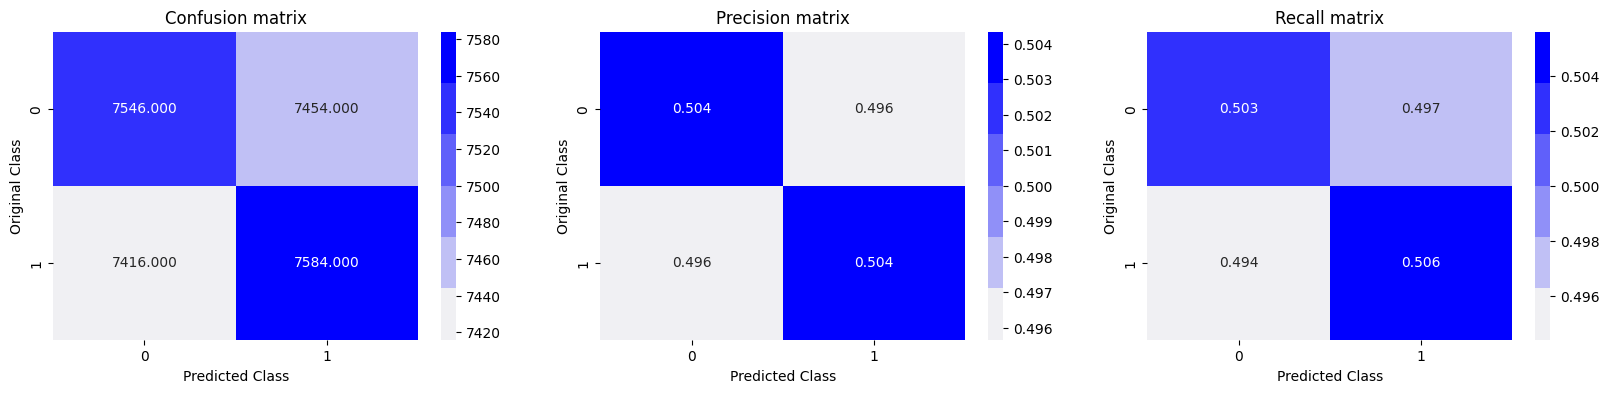

In [ ]:
import scikitplot.metrics as skplt

# we need to generate 9 numbers and the sum of numbers should be 1
# one solution is to genarate 9 numbers and divide each of the numbers by their sum
# we create a output array that has exactly same size as the CV data
predicted_y = np.zeros((test_len,2))
for i in range(test_len):
    rand_probs = np.random.rand(1,2)
    predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Test Data using Random Model",log_loss(y_test, predicted_y, eps=1e-15))
predicted_y =np.argmax(predicted_y, axis=1)

plot_confusion_matrix(y_test, predicted_y)
plt.show()

In [ ]:
print("Classification Report\n",classification_report(y_test,predicted_y))

Classification Report
               precision    recall  f1-score   support

           0       0.50      0.50      0.50     15000
           1       0.50      0.51      0.50     15000

    accuracy                           0.50     30000
   macro avg       0.50      0.50      0.50     30000
weighted avg       0.50      0.50      0.50     30000



##Logistic Regression with hyperparameter tuning

For values of alpha =  1e-05 The log loss is: 0.6931471805599453
For values of alpha =  0.0001 The log loss is: 0.6931471805599453
For values of alpha =  0.001 The log loss is: 0.6931471805599453
For values of alpha =  0.01 The log loss is: 0.6931471805599453
For values of alpha =  0.1 The log loss is: 0.6409253929215067
For values of alpha =  1 The log loss is: 0.6748621054476259
For values of alpha =  10 The log loss is: 0.6311209586892658


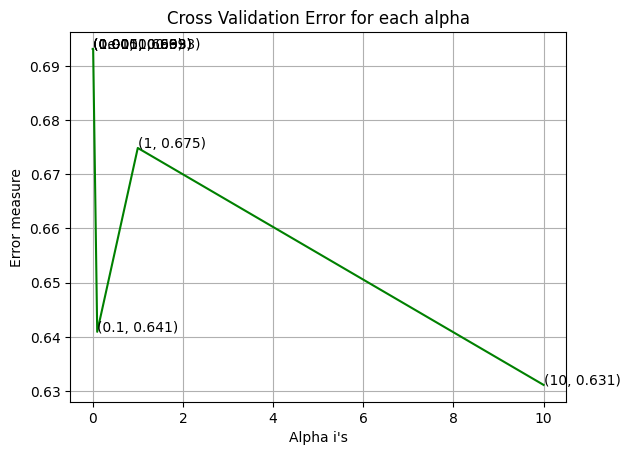

For values of best alpha =  10 The train log loss is: 0.629611662903534
For values of best alpha =  10 The test log loss is: 0.6311209586892658
Total number of data points : 30000


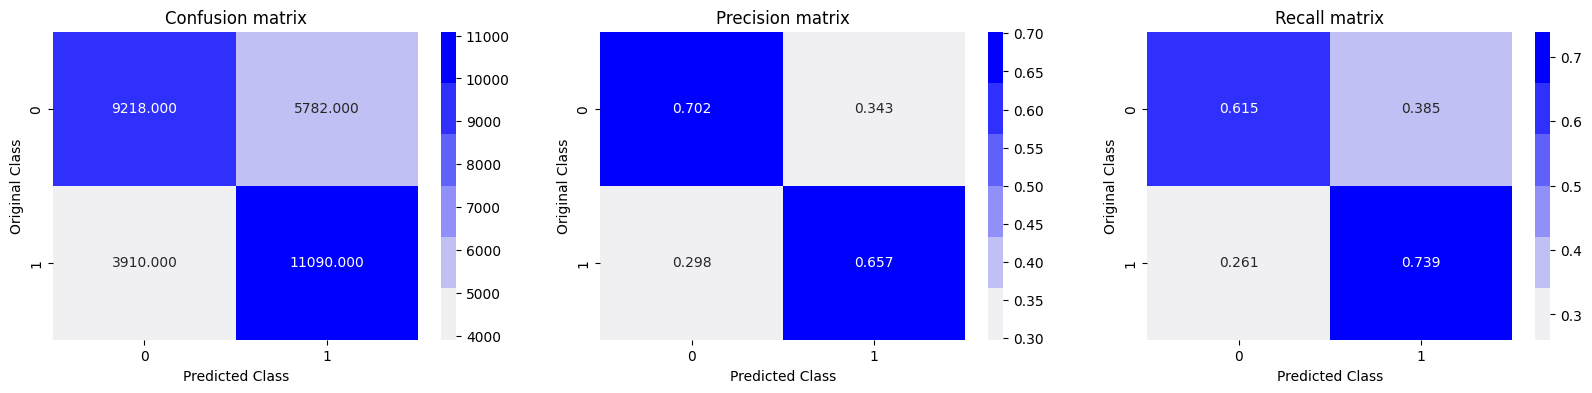

In [ ]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

In [ ]:
print("Classification Report\n",classification_report(y_test,predicted_y))

Classification Report
               precision    recall  f1-score   support

           0       0.70      0.61      0.66     15000
           1       0.66      0.74      0.70     15000

    accuracy                           0.68     30000
   macro avg       0.68      0.68      0.68     30000
weighted avg       0.68      0.68      0.68     30000



##Linear SVM with hyperparameter tuning

For values of alpha =  1e-05 The log loss is: 0.6931471805599453
For values of alpha =  0.0001 The log loss is: 0.6931471805599453
For values of alpha =  0.001 The log loss is: 0.6931471805599453
For values of alpha =  0.01 The log loss is: 0.6931471805599453
For values of alpha =  0.1 The log loss is: 0.6931471805599453
For values of alpha =  1 The log loss is: 0.6028286199936541
For values of alpha =  10 The log loss is: 0.6931471805599453


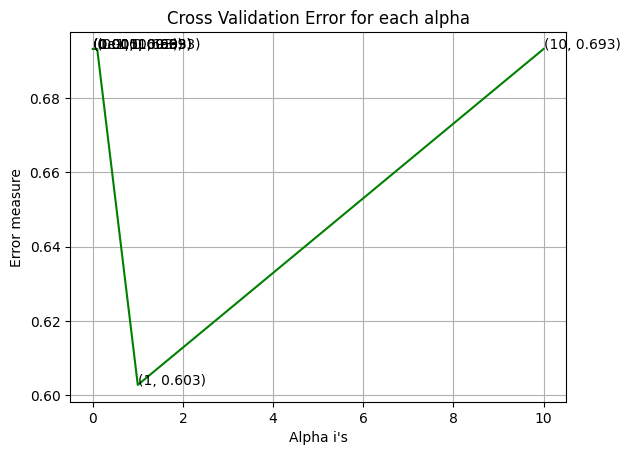

For values of best alpha =  1 The train log loss is: 0.602191918182431
For values of best alpha =  1 The test log loss is: 0.6028286199936541
Total number of data points : 30000


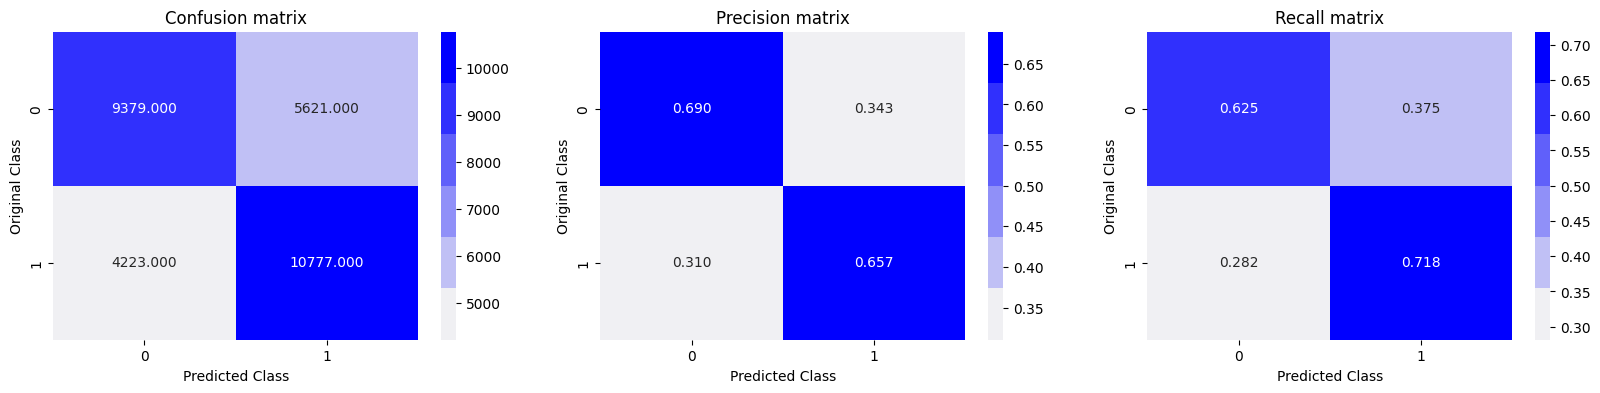

In [ ]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l1', loss='hinge', random_state=42)
    clf.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l1', loss='hinge', random_state=42)
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

In [ ]:
print("Classification Report\n",classification_report(y_test,predicted_y))

Classification Report
               precision    recall  f1-score   support

           0       0.69      0.63      0.66     15000
           1       0.66      0.72      0.69     15000

    accuracy                           0.67     30000
   macro avg       0.67      0.67      0.67     30000
weighted avg       0.67      0.67      0.67     30000



##XGboost with hyperparameter tuning

In [ ]:
import xgboost as xgb
param_grid = {"max_depth":[x for x in range(2,10)],
              "n_estimators":[50,100,150,200,300,400,500]}

In [ ]:
model = RandomizedSearchCV(xgb.XGBClassifier(n_jobs=-1,random_state=25), param_distributions=param_grid,n_iter=30,scoring='neg_log_loss',cv=3,n_jobs=-1)

In [ ]:
model.fit(X_train,y_train)

RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate...
                                           max_cat_to_onehot=None,
                                           max_delta_step=None, max_depth=None,
                                           max_leaves=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           multi_strategy=None,
                                           n_estimators=None, n_jobs=-1,
                                           num_parallel_tree=None,
                                           random_state=25, ...),
                   n_iter=30, n_jobs=-1,
                   param_distributions={'max_depth': [2, 3, 4, 5, 6, 7, 8, 9],
                                        'n_estimators': [50, 100, 150, 200, 300,
                                                         400, 500]},
                   scoring='neg_log_loss')

In [ ]:
model.best_params_

{'n_estimators': 100, 'max_depth': 5}

In [ ]:
clf=xgb.XGBClassifier(n_jobs=-1,random_state=25,max_depth=5,n_estimators=150)

In [ ]:
clf.fit(X_train,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=150, n_jobs=-1,
              num_parallel_tree=None, random_state=25, ...)

Train log loss =  0.24882696596182857  Test log loss =  0.39076112119560524


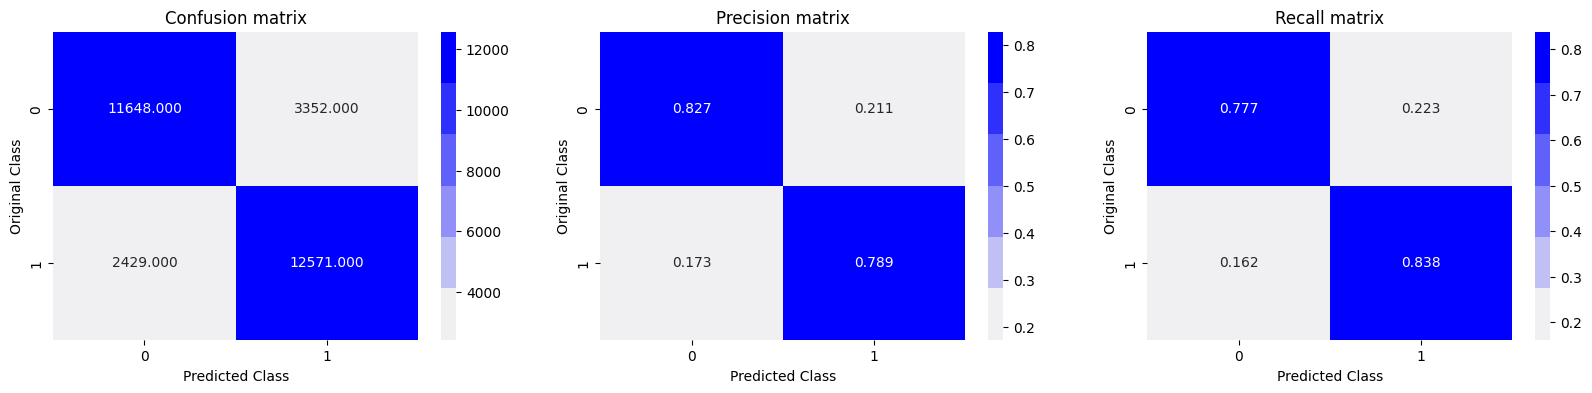

In [ ]:
y_pred_test=clf.predict_proba(X_test)
y_pred_train=clf.predict_proba(X_train)
log_loss_train = log_loss(y_train, y_pred_train, eps=1e-15)
log_loss_test=log_loss(y_test,y_pred_test,eps=1e-15)
print('Train log loss = ',log_loss_train,' Test log loss = ',log_loss_test)
predicted_y=np.argmax(y_pred_test,axis=1)
plot_confusion_matrix(y_test,predicted_y)

In [ ]:
print("Classification Report\n",classification_report(y_test,predicted_y))

Classification Report
               precision    recall  f1-score   support

           0       0.83      0.78      0.80     15000
           1       0.79      0.84      0.81     15000

    accuracy                           0.81     30000
   macro avg       0.81      0.81      0.81     30000
weighted avg       0.81      0.81      0.81     30000

